In [129]:
import pandas as pd
import numpy as np
from collections import Counter
from category_encoders import TargetEncoder
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [150]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [151]:
print('колличество уникальных названий отелей',len(hotels['hotel_name'].unique()))

колличество уникальных названий отелей 1492


In [152]:
#изменяем тип строки на дату
hotels['review_date'] = pd.to_datetime(hotels['review_date'], errors='coerce')
print('самый свежий отзыв оставлен', hotels['review_date'].max())
print('самый первый отзыв оставлен', hotels['review_date'].min())

самый свежий отзыв оставлен 2017-08-03 00:00:00
самый первый отзыв оставлен 2015-08-04 00:00:00


In [153]:
# Теги. Преобразование строковых переменных в списки.

hotels['tags'] = hotels['tags'].apply(lambda x: x[3:-3].split(' \', \' '))

In [154]:
c = Counter(tag for row in hotels['tags'] for tag in row)
print(len(c))

2368


In [155]:
# Запускаем кодирование для наиболее частых тегов. Граница для
# наиболее часто берется 5% от размера набора данных.

boundary = hotels.shape[0] * 0.05  # 5% граница
frequent_tags_count = dict(filter(lambda x: x[1] > boundary, c.items()))
print('Наиболее часто встречающиеся теги и их количество:')
frequent_tags_count


Наиболее часто встречающиеся теги и их количество:


{'Leisure trip': 313593,
 'Couple': 189212,
 'Stayed 2 nights': 100263,
 'Submitted from a mobile device': 230778,
 'Business trip': 61989,
 'Standard Double Room': 24151,
 'Stayed 1 night': 145373,
 'Solo traveler': 81235,
 'Stayed 3 nights': 72000,
 'Superior Double Room': 23550,
 'Stayed 4 nights': 35748,
 'Double Room': 26386,
 'Family with young children': 45836,
 'Group': 49088,
 'Family with older children': 19802}

In [156]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

<AxesSubplot: >

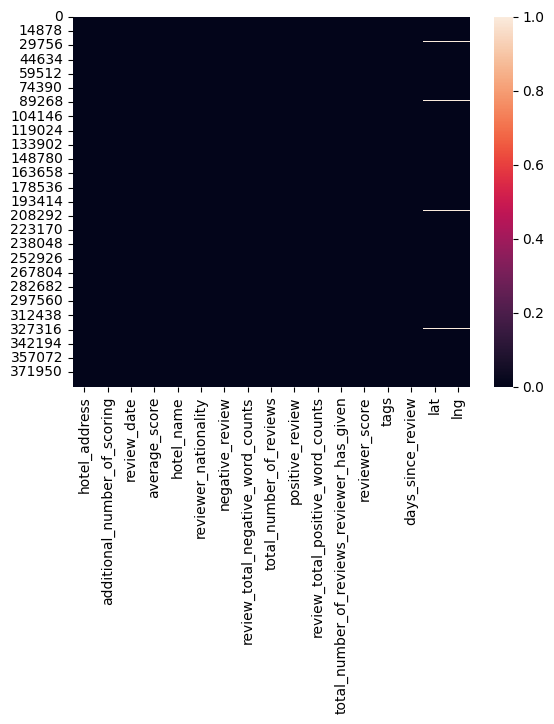

In [157]:
import seaborn as sns
sns.heatmap(hotels.isnull()) # наглядная карта пропусков

In [158]:
#заменяем пропущенные значения на mean
hotels['lat'] = hotels['lat'].fillna(hotels['lat'].mean())
hotels['lng'] = hotels['lng'].fillna(hotels['lng'].mean())

In [159]:
# Извлечение некоторой информации из даты проверки.
#
# День года кодируется синусом и косинусом, чтобы отразить цикличность
# процесс. Одновременно с числовым описанием календарной даты
# позволяет нам кодировать смену времен года более точным способом, чем обычный
# 4-сезонный дивизион. Индикаторы Рождества и выходных дней дополнительно
# включено.

hotels['review_date'] = pd.to_datetime(hotels['review_date'])

hotels['sin_date'] = np.sin(2 * np.pi * hotels['review_date'].dt.dayofyear / 365)
hotels['cos_date'] = np.cos(2 * np.pi * hotels['review_date'].dt.dayofyear / 365)

hotels['christmas'] = hotels['review_date'].apply(lambda x: 
    1 if (x.month==12 and x.day>=25) or (x.month==1 and x.day<=5) else 0)
hotels['weekend'] = hotels['review_date'].apply(lambda x: 
    1 if x.dayofweek==5 or x.dayofweek==6 else 0)

In [162]:
frequent_tags = list(dict(filter(lambda x: 
    x[1]>boundary and x[0].split()[0]!='Stayed', 
    frequent_tags_count.items())).keys())
frequent_tags

['Leisure trip',
 'Couple',
 'Submitted from a mobile device',
 'Business trip',
 'Standard Double Room',
 'Solo traveler',
 'Superior Double Room',
 'Double Room',
 'Family with young children',
 'Group',
 'Family with older children']

In [163]:
# Быстрое кодирование для частых тегов.

for tag in frequent_tags:
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)

In [164]:
# Преобразование функции «days_since_review» в хронологический порядок
# даты проверки: с 0 дня до последнего дня.

hotels['days_since_review'] \
    = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))
hotels['day_number'] \
    = (hotels['days_since_review']-hotels['days_since_review'].max()) * (-1)

In [167]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

In [169]:
hotels.drop(['review_date'], axis=1, inplace=True)

In [170]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int64  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

# Обучение модели

In [171]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [172]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [173]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [174]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [175]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13627629320691134


Небольшой бонус:


In [10]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)